In [ ]:
# Reference: https://stackoverflow.com/questions/41707229/tqdm-printing-to-newline
from functools import partial
from tqdm import tqdm

tqdm = partial(tqdm, position=0, leave=True)

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import matplotlib.pyplot as plt
import os
import xml.etree.ElementTree as ET 
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import resnet18

from PIL import Image

%cd /content/drive/MyDrive/Key-points-detection/
from util import *
from dataset import *
%cd /content/

/content/drive/MyDrive/Key-points-detection
/content


# Load Data

In [ ]:
# Reference: https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/download_ibug_dataset.txt

%%capture
if not os.path.exists('/content/ibug_300W_large_face_landmark_dataset'):
    !wget https://people.eecs.berkeley.edu/~zhecao/ibug_300W_large_face_landmark_dataset.zip
    !unzip 'ibug_300W_large_face_landmark_dataset.zip'    
    !rm -r 'ibug_300W_large_face_landmark_dataset.zip'

In [ ]:
# This snippet of code is from https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/
# Exact location: https://inst.eecs.berkeley.edu/~cs194-26/fa20/hw/proj4/load_ibug_dataset.py

tree = ET.parse('ibug_300W_large_face_landmark_dataset/labels_ibug_300W_train.xml')
root = tree.getroot()
root_dir = 'ibug_300W_large_face_landmark_dataset'

bboxes = [] # face bounding box used to crop the image
landmarks = [] # the facial keypoints/landmarks for the whole training dataset
img_filenames = [] # the image names for the whole dataset

for filename in root[2]:
    img_filenames.append(os.path.join(root_dir, filename.attrib['file']))
    box = filename[0].attrib
    # x, y for the top left corner of the box, w, h for box width and height
    bboxes.append([box['left'], box['top'], box['width'], box['height']]) 

    landmark = []
    for num in range(68):
        x_coordinate = int(filename[0][num].attrib['x'])
        y_coordinate = int(filename[0][num].attrib['y'])
        landmark.append([x_coordinate, y_coordinate])
    landmarks.append(landmark)

landmarks = np.array(landmarks).astype('float32')     
bboxes = np.array(bboxes).astype('float32')

# Define training hyperparameters and functions

In [ ]:
BATCH_SIZE = 64
EPOCH_SIZE = 100
lr = 5e-4
weight_decay = 1e-5
momentum = 0.9
TRAIN_VAL_SPLIT = 0.95
BATCH_INTERVAL = 150  # do a validation per BATCH_INTERVAL

In [ ]:
transform = Compose([
    ResizeAndRandomRotate(15, size=(224, 224)),
    ToTensor()
])

In [ ]:
dataset = MyDataset('/content', img_filenames, landmarks, transform=transform)

train_data_size = int(len(dataset) * TRAIN_VAL_SPLIT)
val_data_size = len(dataset) - train_data_size

# Split trainning and validation dataset
train_set, val_set = torch.utils.data.random_split(dataset, lengths=(train_data_size, val_data_size))
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
test_loader = DataLoader(val_set, batch_size=BATCH_SIZE, num_workers=4)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
resnet = resnet18(num_classes=136)
resnet.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
resnet = resnet.to(device)

In [ ]:
optimizer = optim.Adam(resnet.parameters(), lr=lr, weight_decay=weight_decay)

In [ ]:
l2_loss = nn.L1Loss().to(device) # This is actually L1 loss

In [ ]:
def criterion(output, target):
    target = target.to(device)
    return l2_loss(output, target)

In [ ]:
%matplotlib inline
def test():
    """
    Do a validation on current model
    """
    resnet.eval()
    val_loss = 0
    for batch_size, (image, anno) in enumerate(test_loader):
        image = image.to(device)
        out = resnet(image)
        val_loss += criterion(out, anno)
        if batch_size == 0:
            show_image(image, out)
    return val_loss

In [ ]:
import torch.nn.functional as F
def train(start_batch=0, state_dict=None):
    resnet.train()
    train_loss_hist = []
    test_loss_hist = []
    # if state_dict is not None:
        

    for i in range(EPOCH_SIZE):
        print(f'=======Epoch{i + 1}/{EPOCH_SIZE}==========')
        total_loss = 0
        for batch_i, (image, annotations) in enumerate(tqdm(train_loader)):
            optimizer.zero_grad()
            image = image.to(device)
            out = resnet(image)

            train_loss = criterion(out, annotations)
            train_loss.backward()
            optimizer.step()
            total_loss += float(train_loss)

            # calculate validation loss and save model
            # print(batch_i)
            if (batch_i + 1) % BATCH_INTERVAL == 0 or (batch_i + 1) == len(train_loader):
                resnet.eval()
                with torch.no_grad():
                    test_loss = test()
                    test_loss_hist.append(test_loss / val_data_size)
                    train_loss_hist.append(total_loss / train_data_size)
                    if not os.path.exists('model'):
                        os.mkdir('model')
                    torch.save(resnet.state_dict(), f'model/EPOCH_{i}_BATCH_{batch_i}.pth')
                print('========================================================================================')
                print(f'=========Train Loss is: {total_loss / train_data_size}==========Validation Loss is: {test_loss / val_data_size}')
                print('========================================================================================')
                resnet.train()

    plot_loss(train_loss_hist, test_loss_hist)

In [ ]:
train()

  0%|          | 0/99 [00:00<?, ?it/s]

=======Epoch1/100==========


# Eval trained model

In [ ]:
# !ls model/

ls: cannot access 'model/': No such file or directory


In [ ]:
# !rm -r model/

In [ ]:
# !wget https://1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com/wp-content/uploads/shutterstock_149962697-946x658.jpg

--2020-11-20 11:03:44--  https://1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com/wp-content/uploads/shutterstock_149962697-946x658.jpg
Resolving 1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com (1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com)... 94.31.29.99
Connecting to 1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com (1vw4gb3u6ymm1ev2sp2nlcxf-wpengine.netdna-ssl.com)|94.31.29.99|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 35244 (34K) [image/jpeg]
Saving to: ‘shutterstock_149962697-946x658.jpg’

shutterstock_149962 100%[===================>]  34.42K  --.-KB/s    in 0.003s  

2020-11-20 11:03:45 (10.2 MB/s) - ‘shutterstock_149962697-946x658.jpg’ saved [35244/35244]



In [ ]:
# !wget https://ggia.berkeley.edu/assets/general/GGIA-HumanFace.jpg

--2020-11-20 11:03:46--  https://ggia.berkeley.edu/assets/general/GGIA-HumanFace.jpg
Resolving ggia.berkeley.edu (ggia.berkeley.edu)... 169.229.216.14
Connecting to ggia.berkeley.edu (ggia.berkeley.edu)|169.229.216.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60257 (59K) [image/jpeg]
Saving to: ‘GGIA-HumanFace.jpg’

GGIA-HumanFace.jpg  100%[===================>]  58.84K   197KB/s    in 0.3s    

2020-11-20 11:03:48 (197 KB/s) - ‘GGIA-HumanFace.jpg’ saved [60257/60257]



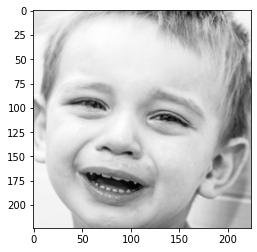

In [ ]:

# Image must be first converted to grayscale and then resized to 224, 224. 
# For better result, you may need to manaully crop the image

# Ex: image = Image.open('GGIA-HumanFace.jpg').convert('L').crop((200, 0, 600, 430)).resize((224, 224))
# image.crop(box) box – a 4-tuple defining the left, upper, right, and lower pixel coordinate.

# image = Image.open('shutterstock_149962697-946x658.jpg').convert('L')
# image = Image.open('shutterstock_149962697-946x658.jpg').convert('L').crop((300, 0, 700, 550)).resize((224, 224))
image = Image.open('GGIA-HumanFace.jpg').convert('L').crop((200, 0, 600, 430)).resize((224, 224))

to_tensor = transforms.ToTensor()
tensor = to_tensor(image).unsqueeze(0)

plt.imshow(image, cmap='gray')
plt.show()

In [ ]:
# !mv /content/model/EPOCH_48_BATCH_98.pth /content/drive/MyDrive/

In [ ]:
# load data, look at the model folder for which model you want to use

epoch_number = 48  # modify this line
batch_number = 98  # modify this line

model_path = '/content/model/' + f'EPOCH_{epoch_number}_BATCH_{batch_number}.pth' # modify model path
# model_path = '/content/drive/My Drive/Key-points-detection/model/' + f'EPOCH_{epoch_number}_BATCH_{batch_number}.pth' 

In [ ]:
def load_dict(model, path, eval=False):
    model = resnet18(num_classes=136)
    model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
    model.load_state_dict(torch.load(path))
    if eval:
        model.eval()
    return model

In [ ]:
%%capture
model = resnet18(num_classes=136)
model.conv1 = nn.Conv2d(1, 64, 7, 2, 3, bias=False)
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
def show(image, anno):
    anno = anno.squeeze(0)
    plt.imshow(image, cmap='gray')
    plt.scatter(anno[:68], anno[68:])
    plt.show()

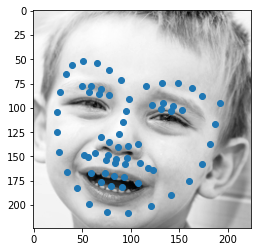

In [ ]:
with torch.no_grad():
    out = model(tensor)
    show(image, out)